In [16]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle

In [27]:
DATA_DIR = '/mnt/chicm/data/open-images/relation'
DETECT_DATA_DIR = '/mnt/chicm/data/open-images/detect'

In [70]:
df_detect_test = pd.read_csv(os.path.join(DETECT_DATA_DIR, 'sample_submission.csv'))
df_detect_test.head()

,ImageId,PredictionString
0,b5d912e06f74e948,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
1,be137cf6bb0b62d5,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
2,8d65ca08cb5ce8e8,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
3,4d3ad1e52ad8c065,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
4,9b94408691c7d7bf,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...


In [9]:
!ls /mnt/chicm/data/open-images/relation

challenge-2019-attributes-description.csv
challenge-2019-classes-vrd.csv
challenge-2019-relationships-description.csv
challenge-2019-relationship-triplets.csv
challenge-2019-train-vrd-bbox.csv
challenge-2019-train-vrd.csv
challenge-2019-train-vrd-labels.csv
challenge-2019-validation-vrd-bbox.csv
challenge-2019-validation-vrd.csv
challenge-2019-validation-vrd-labels.csv
top_classes.csv
VRD_sample_submission.csv


In [49]:
df_test = pd.read_csv(os.path.join(DATA_DIR, 'VRD_sample_submission.csv'))
df_test.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
1,763c72626bf24534,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
2,7540c162180973b1,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
3,c4e522dce52cb02f,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
4,cafcd9496c808085,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...


In [73]:
df_test.loc[df_test.ImageId=='4d3ad1e52ad8c065']

,ImageId,PredictionString
4750,4d3ad1e52ad8c065,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...


In [13]:
df_des = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-classes-vrd.csv'), names=['label', 'name'])
df_des.head()

,label,name
0,/m/05r5c,Piano
1,/m/01599,Beer
2,/m/01_5g,Chopsticks
3,/m/01yrx,Cat
4,/m/04_sv,Motorcycle


In [68]:
df_des.name.values

array(['Piano', 'Beer', 'Chopsticks', 'Cat', 'Motorcycle',
       'Tennis racket', 'Football', 'Mobile phone', 'Flute',
       'Tennis ball', 'Chair', 'Woman', 'Boy', 'Coffee table', 'Handbag',
       'Fork', 'Girl', 'Coffee cup', 'Violin', 'Backpack', 'Knife',
       'Snowboard', 'Rugby ball', 'Snake', 'Oven', 'Microwave oven',
       'Man', 'Bench', 'Desk', 'Suitcase', 'Sofa bed', 'Horse',
       'Microphone', 'Table tennis racket', 'Monkey', 'Surfboard',
       'Table', 'Bottle', 'Mug', 'Wine glass', 'Drum', 'Dog', 'Guitar',
       'Ski', 'Bed', 'Spoon', 'Briefcase', 'Hamster', 'Car', 'Bicycle',
       'Camera', 'Dolphin', 'Taxi', 'Van', 'Elephant', 'Racket',
       'Pretzel'], dtype=object)

In [14]:
df_des.shape

(57, 2)

In [15]:
# visualize

import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


In [20]:
!ls /mnt/chicm/open-images-vrd/work_dirs/rel_cas -lh

total 3.3G
-rw-rw-r-- 1 core core  72K Jul 22 16:14 20190721_160136.log
-rw-rw-r-- 1 core core  75K Jul 22 16:14 20190721_160136.log.json
-rw-rw-r-- 1 core core 253K Jul 22 16:14 20190722_011137.log
-rw-rw-r-- 1 core core 261K Jul 22 16:14 20190722_011137.log.json
-rw-rw-r-- 1 core core  655 Jul 22 16:21 20190722_162006.log
-rw-rw-r-- 1 core core  384 Jul 22 16:21 20190722_162006.log.json
-rw-rw-r-- 1 core core 1.5G Jul 22 16:14 epoch_1.pth
-rw-rw-r-- 1 core core 1.5G Jul 22 16:14 epoch_2.pth
lrwxrwxrwx 1 core core   52 Jul 22 16:14 latest.pth -> /mnt/chicm/open-images/work_dirs/rel_cas/epoch_2.pth
-rw-rw-r-- 1 core core 438M Jul 22 16:14 preds_0722.pkl


In [18]:
def get_top_classes(start_index, end_index):
    df = pd.read_csv(os.path.join(DATA_DIR, 'top_classes.csv'))
    c = df['class'].values[start_index:end_index]
    #print(df.head())
    stoi = { c[i]: i for i in range(len(c)) }
    return c, stoi
classes, stoi = get_top_classes(0, 57)

In [19]:
# submission

with open('/mnt/chicm/open-images-vrd/work_dirs/rel_cas/preds_0722.pkl', 'rb') as f:
    preds = pickle.load(f)


In [21]:
len(preds[0])

57

In [22]:
classes[:5]

array(['/m/04yx4', '/m/03bt1vf', '/m/0k4j', '/m/05r655', '/m/01mzpv'],
      dtype=object)

In [77]:
th = 0.1
def get_preds(raw_pred):
    res = {
        'labels': [],
        'scores': [],
        'bboxes': []
    }
    for i, p in enumerate(raw_pred):
        if len(p) > 0:
            for e in p:
                #th = get_threshold(classes[i])
                if True:
                #if e[4] > th:
                    res['labels'].append(i)
                    res['scores'].append(e[4])
                    res['bboxes'].append(e[:4])
    res['labels'] = np.array(res['labels'])
    res['scores'] = np.array(res['scores'])
    res['bboxes'] = np.array(res['bboxes'])
    return res

In [497]:
#print(get_preds(preds[0]))
#tmp = get_preds(preds[0])['labels']
#print(get_preds(preds[0])['scores'])
#print(tmp)
#tmp = [classes[i] for i in tmp]
#print(tmp)
#tmp = [df_des.loc[df_des.label==x].name.values.tolist()[0] for x in tmp]
#print(tmp)

In [78]:
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'
def show_preds(idx):
    plt.figure(figsize=(15, 10))
    p = get_preds(preds[idx])
    img_id = df_test.iloc[idx].ImageId
    fn = os.path.join(TEST_IMG_DIR, '{}.jpg'.format(img_id))
    img = Image.open(fn)
    draw_bounding_boxes_on_image(img, p['bboxes'])
    
    plt.imshow(img)
    labels = [classes[i] for i in p['labels']]
    labels = [df_des.loc[df_des.label==x].name.values[0] for x in labels]
    #print(labels)
    print(list(zip(labels, p['scores'])))

[('Man', 0.14973567), ('Man', 0.0745361), ('Man', 0.011002406), ('Man', 0.004705208), ('Woman', 0.067867294), ('Woman', 0.061681427), ('Girl', 0.013199711), ('Girl', 0.008985045), ('Chair', 0.047661684), ('Chair', 0.029187221), ('Chair', 0.022900151), ('Chair', 0.015722478), ('Chair', 0.01520459), ('Chair', 0.013203651), ('Chair', 0.011904128), ('Chair', 0.004517337), ('Boy', 0.06492905), ('Boy', 0.057689764), ('Table', 0.66918486), ('Table', 0.2508601), ('Table', 0.066571854), ('Table', 0.015668107), ('Table', 0.013076461), ('Table', 0.0071184793), ('Table', 0.0056596464), ('Table', 0.0050273812), ('Table', 0.0034087105), ('Bicycle', 0.004627156), ('Drum', 0.00814356), ('Drum', 0.006682295), ('Motorcycle', 0.005845083), ('Horse', 0.0038988558), ('Wine glass', 0.006842856), ('Bench', 0.087666705), ('Bench', 0.017452337), ('Coffee cup', 0.017370392), ('Coffee cup', 0.0042009363), ('Coffee table', 0.03528307), ('Coffee table', 0.033257544), ('Bed', 0.022744833), ('Elephant', 0.009346967)

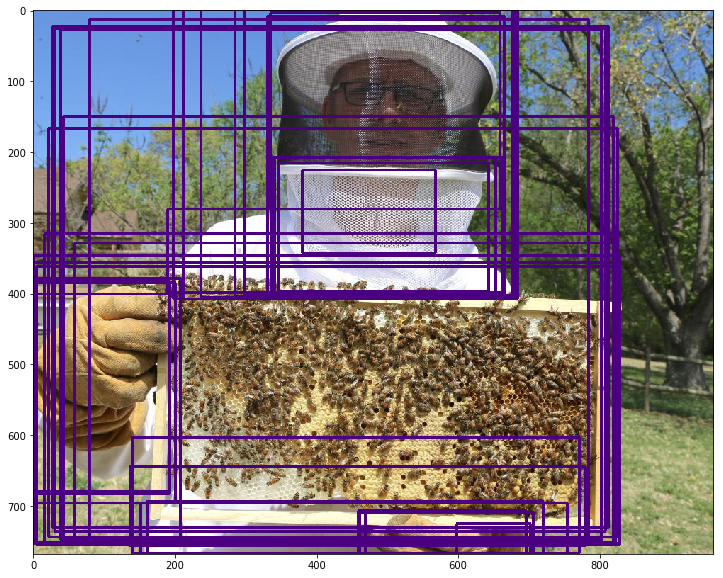

In [76]:
show_preds(4750)

In [79]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            raise AssertionError('imghead len != 24')
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                raise AssertionError('png check failed')
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                raise
        else:
            print(fname, imghdr.what(fname))
            #raise AssertionError('file format not supported')
            img = cv2.imread(fname)
            print(img.shape)
            height, width, _ = img.shape

        return width, height


In [80]:
df_test['h'] = df_test.ImageId.map(lambda x: get_image_size(os.path.join(TEST_IMG_DIR, '{}.jpg'.format(x)))[1])

In [81]:
df_test['w'] = df_test.ImageId.map(lambda x: get_image_size(os.path.join(TEST_IMG_DIR, '{}.jpg'.format(x)))[0])

In [82]:
df_test.head()

,ImageId,PredictionString,h,w
0,21135d5ed0e7a0b7,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024
1,763c72626bf24534,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,681,1024
2,7540c162180973b1,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024
3,c4e522dce52cb02f,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,768,1024
4,cafcd9496c808085,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024


In [83]:
final_preds = []

for p in tqdm(preds, total=len(preds)):
    final_preds.append(get_preds(p))

100%|██████████| 99999/99999 [00:11<00:00, 8753.41it/s] 


In [84]:
total_objs = 0
for p in final_preds:
    total_objs += len(p['labels'])
print(total_objs)

4636236


In [85]:
def get_pred_str(pred, w, h):
    res = []
    for label, score, bbox in zip(pred['labels'], pred['scores'], pred['bboxes']):
        res.append(classes[label])
        res.append('{:.7f}'.format(score))
        res.append('{:.7f}'.format(bbox[0]/w))
        res.append('{:.7f}'.format(bbox[1]/h))
        res.append('{:.7f}'.format(bbox[2]/w))
        res.append('{:.7f}'.format(bbox[3]/h))
    res = [str(x) for x in res]
    return ' '.join(res)

In [86]:
pred_strs = []
for i, p in tqdm(enumerate(final_preds), total=len(final_preds)):
    h = df_test.iloc[i].h
    w = df_test.iloc[i].w
    pred_strs.append(get_pred_str(p, w, h))
    

100%|██████████| 99999/99999 [02:04<00:00, 803.10it/s]


In [87]:
pred_strs[:5]

['/m/04yx4 0.7549744 0.0000000 0.1213381 0.4315295 0.9640482 /m/04yx4 0.7175171 0.3678661 0.2426784 0.7441021 0.9876140 /m/04yx4 0.2618945 0.6670353 0.1531863 0.8283385 0.7385658 /m/04yx4 0.1281361 0.4435898 0.0967678 0.7538665 0.7661543 /m/04yx4 0.1280699 0.5055012 0.0907769 0.7015533 0.4613100 /m/04yx4 0.0745831 0.5178590 0.0947947 0.6969838 0.2946458 /m/04yx4 0.0540965 0.3751285 0.3350994 0.5346580 0.7736871 /m/04yx4 0.0534608 0.8008983 0.1302080 0.9990234 0.6647361 /m/04yx4 0.0522914 0.6342883 0.1619661 0.9713494 0.7194502 /m/04yx4 0.0376271 0.0000000 0.2225823 0.0902728 0.7816297 /m/03bt1vf 0.1545253 0.6655371 0.1522975 0.8317553 0.7416681 /m/03bt1vf 0.1416807 0.3681697 0.2410129 0.7433268 0.9884523 /m/03bt1vf 0.1292718 0.0000000 0.1261075 0.4126655 0.9535749 /m/03bt1vf 0.0453576 0.4628195 0.0868811 0.7144434 0.5734717 /m/05r655 0.0683029 0.6641279 0.1530531 0.8293261 0.7396210 /m/05r655 0.0369211 0.8021936 0.1296932 0.9990234 0.6420161 /m/01mzpv 0.4466539 0.0203321 0.6938528 0.40

In [88]:
len(pred_strs)

99999

In [89]:
df_test.PredictionString = pred_strs
df_test.head()

,ImageId,PredictionString,h,w
0,21135d5ed0e7a0b7,/m/04yx4 0.7549744 0.0000000 0.1213381 0.43152...,682,1024
1,763c72626bf24534,/m/04yx4 0.9219856 0.0016186 0.1897768 0.25732...,681,1024
2,7540c162180973b1,/m/04yx4 0.6974359 0.5084532 0.0000000 0.60996...,682,1024
3,c4e522dce52cb02f,/m/04yx4 0.8264070 0.0000000 0.1761055 0.21462...,768,1024
4,cafcd9496c808085,/m/0k4j 0.0046642 0.8008922 0.0305311 0.999023...,682,1024


In [90]:
df_test.to_csv('sub_detect_0722_1.csv', index=False, columns=['ImageId', 'PredictionString'])

In [92]:
!head -n 2 sub_detect_0722_1.csv

ImageId,PredictionString
21135d5ed0e7a0b7,/m/04yx4 0.7549744 0.0000000 0.1213381 0.4315295 0.9640482 /m/04yx4 0.7175171 0.3678661 0.2426784 0.7441021 0.9876140 /m/04yx4 0.2618945 0.6670353 0.1531863 0.8283385 0.7385658 /m/04yx4 0.1281361 0.4435898 0.0967678 0.7538665 0.7661543 /m/04yx4 0.1280699 0.5055012 0.0907769 0.7015533 0.4613100 /m/04yx4 0.0745831 0.5178590 0.0947947 0.6969838 0.2946458 /m/04yx4 0.0540965 0.3751285 0.3350994 0.5346580 0.7736871 /m/04yx4 0.0534608 0.8008983 0.1302080 0.9990234 0.6647361 /m/04yx4 0.0522914 0.6342883 0.1619661 0.9713494 0.7194502 /m/04yx4 0.0376271 0.0000000 0.2225823 0.0902728 0.7816297 /m/03bt1vf 0.1545253 0.6655371 0.1522975 0.8317553 0.7416681 /m/03bt1vf 0.1416807 0.3681697 0.2410129 0.7433268 0.9884523 /m/03bt1vf 0.1292718 0.0000000 0.1261075 0.4126655 0.9535749 /m/03bt1vf 0.0453576 0.4628195 0.0868811 0.7144434 0.5734717 /m/05r655 0.0683029 0.6641279 0.1530531 0.8293261 0.7396210 /m/05r655 0.0369211 0.8021936 0.1296932 0.9990234 0.6420161 /m/0